# PA3

In this assignment, you will perform logistic regression on the MNIST dataset to detect which number is written in an image! Each image in the MNIST data shows a handwritten number, and your goal is to use logistic regression to detect when a number is an "8" or a "1".

First, you will train logistic regression to recognize the digit 8. You'll do this once with coordinate descent (CD) and once with SGD (discussed in class). Then, you'll train logistic regression to recognize the digit 1, using your preferred method between CD and SGD.

Fill in the ACT's below. Writing asserts to test your code is recommended, but not graded for this assignment.

Install/add Tensforflow to your python installation before executing the following.

In [1]:
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, y_train), (X_test, y_test) = keras_mnist.load_data()

In [2]:
# There are 60000 training examples, each example is a 28 by 28 pixel
# grayscale image, represented by a 28 by 28 array of numbers
print('Shape of X_train: ', X_train.shape)

Shape of X_train:  (60000, 28, 28)


## Log-Loss and Its Gradient

In lecture, we used the convention that negative examples are labeled $-1$ and positive examples are labeled $+1$. That is, $y_i\in\{-1,+1\}$. We found that, if $\mathcal{L}(\mathbf{w})$ is our loss on $\mathbf{w}$, and $|S|$ is the number of examples,
$$\mathcal{L}(\mathbf{w}) = \frac{1}{|S|} \sum_{i\in S} \log\big(1+e^{-z_i}\big)
~~ \mbox{ where } ~~
z_i = y_i (\mathbf{w} \cdot \mathbf{x}_i) ~~ .$$
This occurs when we let $\mathcal{L}(\mathbf{w})$ be the negative log probability of us predicting the right label. Note: Sometimes, in lecture we used $\mathcal{L}(\mathbf{w}) = \sum_{i\in S} \log(1+e^{-z_i})$, omitting the division by $|S|$. Since we generally assume that the number of examples $|S|$ is fixed, these two forms of the loss differ by a constant factor, so they are pretty much equivalent.

Alternatively, suppose we use a different convention, that negative examples are labeled $0$ instead. That is, $y_i\in\{0,1\}$. Just as in the previous case, we predict $+1$ with probability $\hat{y}_i = 1/(1+e^{-\mathbf{w} \cdot \mathbf{x_i}})$. Thus, we predict $0$ with probability $1 - \hat{y}_i = 1 - 1/(1+e^{-\mathbf{w} \cdot \mathbf{x_i}}) = 1/(1+e^{\mathbf{w} \cdot \mathbf{x_i}})$.

Then, observe that the probability of predicting the right label is equal to $\hat{y}_i$ when $y_i = 1$, and is equal to $1 - \hat{y}_i$ when $y_i = 0$. Then, do you see why the loss can be expressed as the following? (You can plug in $y_i = 1$ or $y_i = 0$.)
$$\mathcal{L}(\mathbf{w}) =
  -\frac{1}{|S|} \sum_{i\in S} \big(y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\big)
~~ \mbox{ where } ~~ 
\hat{y}_i = \frac{1}{1+e^{-\mathbf{w} \cdot \mathbf{x_i}}}
~~.$$

If we find the gradient for the first form (when $y_i\in\{-1,+1\}$), we obtain the following:
$$ \nabla_{\mathbf{w}} \mathcal{L} = -\frac{1}{|S|} \sum_{i\in S} q_i y_i \mathbf{x}_i 
~~ \mbox{ where } ~~ q_i = \frac{1}{1 + e^{z_i}} ~~ .
$$

For the second form (when $y_i\in\{0,+1\}$), we find that the gradient is:
$$ \nabla_{\mathbf{w}} \mathcal{L} = \frac{1}{|S|} \sum_{i\in S} \big(\hat{y}_i - y_i\big) \mathbf{x}_i  ~~ ,$$
where $\hat{y}_i$ is as defined above. You can verify these gradient values for yourself.

For your own practice (ungraded), you should confirm the equivalence of these two forms, and derive them for yourself. That is, calculate both gradients (see if you get the same thing we did). Then, verify that when you plug in $y_i = 1$ you get the same thing, and when you plug in $y_i = -1$ or $=0$ respectively, you get the same thing. If you're having trouble with this, please ask on Piazza!

Finally, implement the following functions for the case where $y_i\in\{-1,+1\}$. You will use these functions throughout this notebook.

In [3]:
import numpy as np

# Calculate loss from margins z which is equal to y times X dot w
def logloss_from_z(z):
    return np.mean(np.log(1 + np.exp(-z)))

# Calculate error from margins
def error_from_z(z):
    return np.mean(z <= 0)

# Calculate loss from parameter vector
def logloss(X, y, w, b=0):
    return logloss_from_z(y * np.dot(X, w))

# Calculate error from parameter vector
def error(X, y, w):
    return error_from_z(y * np.dot(X, w))

# Gradient of LogLoss w.r.t. w
def logloss_gradient(X, y, w):
    z = y * np.dot(X, w)
    q = -y / (1 + np.exp(z))
    return np.dot(X.transpose(), q) / len(y)

# Calculate error & loss from parameter vector
def logloss_and_error(X, y, w):
    z = y * np.dot(X, w)
    return logloss_from_z(z), error_from_z(z)

## Setting Initial Bias Using Log-Odds
Total number of positive examples is $n_+$ (pos) and negative $n_-$ (neg). Assume $\mathbf{w}=\mathbf{0}$ except for the weight of the last feature $w_{d}$. Since the last column of $X$ is a vector of ones, we can find the optimal initialization of $w_{d}$. We can write the logistic loss as:
$$\frac1n \sum_{i:y_i=+1} \log(1+\exp(-w_d)) + \frac1n \sum_{i:y_i=-1} \log(1+\exp(w_d))$$
To find the best initialization for $w_d$ we take the derivative of the above expression and compare it to $0$. This gives,
$$
\frac1n  \frac{-n_+}{1 + \exp(w_d)} + \frac1n \frac{n_- \, \exp(w_d)}{1 + \exp(w_d)} = 0
$$
Multiplying by $n$ and by $1+\exp(w_d)$ and rearranging terms yields
$$
n_+ = n_- \exp(w_d) ~ ,
$$
which gives the answer of
$$
w_d = \log\left(\frac{n_+}{n_-}\right) ~.
$$

## Setting Initial Bias Using Log-Odds (ACT's 7-9)
As mentioned above, we don't necessarily want to initialize the bias term of $w$, $w_{d}$, to zero. Below is a small math exercise where you will find the best value to initialize bias.

Total number of positive examples is $n_+$ (pos) and negative $n_-$ (neg). Assume $\mathbf{w}=\mathbf{0}$ except for the weight of the last feature $w_{d}$. Since we have the other entries of $w$ initialized equal to $0$, we can write the logistic loss as the following:
$$\frac1n \sum_{i:y_i=+1} \log(1+\exp(-w_d)) + \frac1n \sum_{i:y_i=-1} \log(1+\exp(w_d))$$
If you're unclear on how we got this, verify it by plugging in $\mathbf{w}$ into the formula for logistic loss. Most of the terms in the dot product equal zero except for the last term in the dot product. For reference: $\exp(-w_d) = e^{-w_d}$.

To find the best initialization for $w_d$, we take the derivative of the above loss, and set it to $0$. The ACT's below ask you to do this, to find the best initial bias. Submit your answer as a LaTeX'd answer within this notebook cell (or make a new notebook cell).

ACT 7: Take the derivative, with respect to $w_{d}$, of the above expression for logistic loss.

The derivative, with respect to $w_d$, is
$$
\frac1n  \frac{-n_+}{1 + \exp(w_d)} + \frac1n \frac{n_- \, \exp(w_d)}{1 + \exp(w_d)}
$$
where $n_+$ is the number of positive examples and $n_-$ is the number of negative examples ($n$ is the total number of examples).

ACT 8: Set the derivative of this to zero, and solve for w_d.

Setting the above derivative to zero yields the equation
$$
\frac1n  \frac{-n_+}{1 + \exp(w_d)} + \frac1n \frac{n_- \, \exp(w_d)}{1 + \exp(w_d)} = 0
$$
We multiply by $n$ on both sides of the equation, and then add $\frac{-n_+}{1 + \exp(w_d)}$ on both sides to get
$$
\frac{n_- \, \exp(w_d)}{1 + \exp(w_d)} = \frac{n_+}{1 + \exp(w_d)}
$$
We can multiply both sides by $1 + \exp(w_d)$ and divide by $n_-$ to get
$$
\exp(w_d) = \frac{n_+}{n_-}
$$
so $w_d = \log(\frac{n_+}{n_-})$

ACT 9: Fill in the value of $w_d$ below which minimizes your initial loss, then code it below. (We've given you a hint, the answer is a log of something.)

As seen in ACT 8, the answer is $\log(\frac{n_+}{n_-})$. Some students had their init_bias coded as returning pos / neg, and then took the log within their ACT 16 instead. I don't recommend coding it this way (it's more confusing) but we won't deduct points for this.
$$
w_d = \log(\frac{n_+}{n_-}) ~.
$$

In [4]:
# Calculate the initial bias from log-odds
def init_bias(pos, neg):
    return np.log(pos / neg)

## Image normalization

Normalize each pixel, by subtracting the average value of that pixel over all images, and dividing by the standard deviation. If bias is non-zero, add a bias term by appending `bias` to each example. Algebraicly, this amounts to flattening an image to a $d$ dimensional vector $\mathbf{x}$ and calaculating average pixel value and variance of pixel values,
$$ m = \mathbb{E}(\mathbf{x}) = \frac 1 d \sum_{i=1}^d x_i ~~~
   s^2 = \mathbb{V}(\mathbf{x}) = \frac 1 d \sum_{i=1}^d x_i^2 - m^2 ~~ . $$
Define $a=s^{-1}$, then the normalized image (represented as a vector) is, ${a (\mathbf{x} - m)}$.

In [5]:
def normalize(X, bias=0):
    n, d = X.shape
    m = np.mean(X, axis=1).reshape(n, 1) * np.ones((1, d))
    s = np.std(X, axis=1).reshape(n, 1) * np.ones((1, d))
    Xn = (X - m) / s
    if bias != 0:
        Xn = np.hstack((Xn, bias * np.ones((n, 1))))
    return Xn

Flatten data set of images: each $p_x \times p_y$ image becomes a 1d vector of size $d = p_x \, p_y$.

This amounts to reshaping $X$ from a $n \times p_x \times p_y$ tensor to a $n \times d$ matrix.

In [6]:
def flatten_images(X):
    s = X.shape
    n = s[0]
    d = np.prod(s[1:])
    return X.reshape(n, d)



Convert the train labels $\mathbf{y}^{\mbox{tr}}$ and test labels $\mathbf{y}^{\mbox{te}}$ to vectors over
$\{-1,+1\}$ indicating whether each example is an 8.

For example, ytr8[i] = -1 if the i-th example is NOT an 8

Similarly to above, viewing the first few entries of ytr8,
may give you some intuition about their contents and structure

In [7]:
ytr8 = (2 * (y_train == 8) - 1).reshape(len(y_train), 1)
yte8 = (2 * (y_test == 8) - 1).reshape(len(y_test), 1)

In [8]:
# Normalize and flatten the training and test images
# You may print Xtr and Xte, or view their shape, to get a feeling for their structure
Xtr = normalize(flatten_images(X_train), bias = 1)
Xte = normalize(flatten_images(X_test), bias = 1)

ACT 12: For coordinate descent use the mean value theorem to form a quadratic upper-bound on the loss for a single coordinate $j$. When using the convention of $y_i\in\{0,1\}$ show that,
    $$
     |S|\cdot\mathcal{L}(\mathbf{w}+\delta\mathbf{1}_j) \leq
       \kappa + \sum_i (\hat{y}_i - y_i) X_{ij} \, \delta + \frac18 \sum_i  X_{ij}^2 \, \delta^2 ~~.
    $$
Here we use $\mathbf{w}+\delta\mathbf{1}_j$ to denote $\mathbf{w}$ plus $\delta$ in the $j$-th coordinate. Hint: The slides titled "Mean Value Theorem" and "Putting It All Together" in the Logistic Regression lecture should be helpful. Please ask on Piazza if you're having trouble understanding ACT 12 or the relevant lecture slides!

Note: The factor of $|S|$ multiplied on the left side is used to make this equation similar to the one proved in lecture. In this notebook we divided error and loss by $|S|$ to get average error or loss. However, in the logistic regression lecture we tried to minimize total loss (a.k.a. we didn't divide loss by $|S|$). Minimizing these two losses _is equivalent_ since $|S|$ is just a constant factor, so we multiply by $|S|$ on the left to keep things consistent with lecture in this ACT.

Answer: Like we did in the lecture slides, let's use $\mathcal{L}(\delta)$ to denote $|S|\cdot\mathcal{L}(\mathbf{w}+\delta\mathbf{1}_j)$. From the mean value theorem, there exists some number $\alpha\in[0, \delta]$ such that
$$\mathcal{L}(\delta) = \mathcal{L}(0) + \mathcal{L}'(0)\delta + \frac 12\mathcal{L}''(\alpha)\delta^2$$
(we are using $\delta$ here instead of $a$ which was used in the slides).

Now, we'd like to plug in $\mathcal{L}'(0)$ and $\mathcal{L}''(\alpha)$. In order to do so, we first need to take the derivative and second derivative of $\mathcal{L}$. We begin with the expression for loss from the $\{0, 1\}$ case, and simplify it to:
$$\mathcal{L}(c) = \sum_i y_i\log(1 + e^{-w\cdot x_i - c X_{ij}}) + (1 - y_i)\log(1 + e^{w\cdot x_i + c X_{ij}})$$
Taking the derivative with respect to $c$ yields
$$\mathcal{L}'(c) = \sum_i y_i \frac{-X_{ij}e^{-w\cdot x_i - cX_{ij}}}{1 + e^{-w\cdot x_i - cX_{ij}}} + (1 - y_i)\frac{X_{ij}e^{w\cdot x_i + cX_{ij}}}{1 + e^{w\cdot x_i + cX_{ij}}}$$
We can simplify each fraction by dividing top and bottom by the exponential term in the numerator:
$$\mathcal{L}'(c) = \sum_i y_i \frac{-X_{ij}}{1 + e^{w\cdot x_i + cX_{ij}}} + (1 - y_i)\frac{X_{ij}}{1 + e^{-w\cdot x_i - cX_{ij}}}$$
Now we take the derivative again, to find the second derivative:
$$\mathcal{L}''(c) = \sum_i \frac{y_iX_{ij}^2 e^{w\cdot x_i + cX_{ij}}}{(1 + e^{w\cdot x_i + cX_{ij}})^2} + \frac{(1 - y_i)X_{ij}^2 e^{-w\cdot x_i - cX_{ij}}}{(1 + e^{-w\cdot x_i - cX_{ij}})^2}$$
we can again simplify each fraction by dividing by the exponential term in each numerator:
$$\mathcal{L}''(c) = \sum_i \frac{y_iX_{ij}^2}{(1 + e^{w\cdot x_i + cX_{ij}})(1 + e^{-w\cdot x_i - cX_{ij}})} + \frac{(1 - y_i)X_{ij}^2}{(1 + e^{w\cdot x_i + cX_{ij}})(1 + e^{-w\cdot x_i - cX_{ij}})}$$
These two fractions are actually the same except for the factors of $y_i$ and $1 - y_i$, so we can sum them together.
$$\mathcal{L}''(c) = \sum_i (y_i + 1 - y_i)\frac{X_{ij}^2}{(1 + e^{w\cdot x_i + cX_{ij}})(1 + e^{-w\cdot x_i - cX_{ij}})}$$
$$\mathcal{L}''(c) = \sum_i \frac{X_{ij}^2}{(1 + e^{w\cdot x_i + cX_{ij}})(1 + e^{-w\cdot x_i - cX_{ij}})}$$
To plug these derivatives into the equation we derived from the mean value theorem, we first find $\mathcal{L}'(0)$ by plugging in $0$ into the equation for $\mathcal{L}'$:
$$\mathcal{L}'(0) = \sum_i y_i \frac{-X_{ij}}{1 + e^{w\cdot x_i}} + (1 - y_i)\frac{X_{ij}}{1 + e^{-w\cdot x_i}}$$
Plugging in $\hat{y}_i = \frac{1}{1 + e^{-w\cdot x_i}}$ and $1 - \hat{y}_i = \frac{1}{1 + e^{w\cdot x_i}}$ yields
$$\mathcal{L}'(0) = \sum_i y_i (-X_{ij})(1 - \hat{y}_i) + (1 - y_i)\hat{y}_iX_{ij}$$
$$\mathcal{L}'(0) = \sum_i -y_iX_{ij}+y_iX_{ij}\hat{y}_i + \hat{y}_iX_{ij} - y_i\hat{y}_iX_{ij}$$
$$\mathcal{L}'(0) = \sum_i (\hat{y}_i - y_i)X_{ij}$$
and this is what we will plug in for $\mathcal{L}'(0)$.

Plugging what we have into the equation from the mean value theorem:
$$\mathcal{L}(\delta) = \mathcal{L}(0) + \sum_i (\hat{y}_i - y_i)X_{ij}\delta + \frac 12\sum_i \frac{X_{ij}^2}{(1 + e^{w\cdot x_i + cX_{ij}})(1 + e^{-w\cdot x_i - cX_{ij}})}\delta^2$$

Just like we did in the lecture slides, we can bound $\frac{1}{(1 + e^{w\cdot x_i + cX_{ij}})(1 + e^{-w\cdot x_i - cX_{ij}})} \leq \frac 14$, plugging this in yields
$$\mathcal{L}(\delta) \leq \mathcal{L}(0) + \sum_i (\hat{y}_i - y_i)X_{ij}\delta + \frac 12\sum_i X_{ij}^2\delta^2$$
as desired. (Since $\mathcal{L}(0)$ doesn't depend on $\delta$, we can assign $\kappa = \mathcal{L}(0)$.)

ACT 13: Denote the $j^{\mbox{th}}$ column of $X$ by $\mathbf{v}_j$ and let $c_j= \|\mathbf{v}_j\|^2$.

Show that the $\delta^\star$ minimizing the above bound $\kappa + \sum_i (\hat{y}_i - y_i) X_{ij} \, \delta + \frac18 \sum_i  X_{ij}^2 \, \delta^2$ is,
$$
\delta^\star = \frac{4}{c_j} (\mathbf{y - \hat{y}) \cdot v_j} = \frac{4}{c_j} \sum_{i=1}^n (y_i - \hat{y}_i)\mathbf{v}_j[i] ~~.
$$

(Note that $\mathbf{v}_j[i] = X_{ij}$.) Hint: Take the derivative and set it equal to zero.

Taking the derivative of this bound and setting it to zero yields
$$\sum_i (\hat{y}_i - y_i) X_{ij} + \delta\frac{1}{4}\sum_i X^2_{ij} = 0$$
Now, note that $c_j = ||v_j||^2 = \sum_i X^2_{ij}$. Plugging this in and rearranging yields the desired expression for delta:
$$\sum_i (\hat{y}_i - y_i) X_{ij} + \delta\frac{1}{4}c_j = 0$$
$$\delta = \frac{4}{c_j} \sum_i (y_i - \hat{y}_i) X_{ij}$$

ACT 14: Of course the above expression assumes that $y_i\in \{0, 1\}$, which is different from our current setting, where $y_i \in \{-1, 1\}$.

Can you rewrite the expression for $\delta^\star$ when $y_i\in\{-1, 1\}$?

Hint: First, re-write $(y_i - \hat{y}_i)$ from the previous setting in terms of the new $y_i$ and $z_i$, or $y_i$ and $q_i$. You should get a simple expression that replaces $(y_i - \hat{y}_i)$. The other terms in the expression for $\delta^\star$ shouldn't change, since they don't depend on $y_i$. Thus, you can just plug in your new expression for $(y_i - \hat{y}_i)$ into the previous expression for $\delta^\star$.

Answer: To convert back to the $\{-1, 1\}$ setting, consider the positive and negative examples in the above summation. Positive examples have $y_i = 1$, so that term in the summation becomes $(1 - \hat{y}_i)\mathbf{v}_j[i]$. Negative examples have $y_i = 0$, so that term in the summation becomes $-\hat{y}_i\mathbf{v}_j[i]$.

Now for positive examples, we can write $1 - \hat{y}_i$ in terms of $z_i$. For positive examples, it is
$$1 - \hat{y}_i = 1 - \frac{1}{1+e^{-\mathbf{w} \cdot \mathbf{x_i}}}$$
Since positive examples have $y_i = 1$, this is equivalent to:
$$1 - \hat{y}_i = 1 - \frac{1}{1+e^{-y_i\mathbf{w} \cdot \mathbf{x_i}}} = 1 - \frac{1}{1+e^{-z_i}} = \frac{1}{1+e^{z_i}} = \frac{y_i}{1+e^{z_i}}$$

Now, for negative examples, we can write $-\hat{y}_i$ in terms of $z_i$ as well. It is:
$$-\hat{y}_i = - \frac{1}{1+e^{-\mathbf{w} \cdot \mathbf{x_i}}} = -\frac{1}{1+e^{z_i}}$$
Since negative examples have $y_i = -1$, this is equivalent to:
$$-\hat{y}_i = - \frac{1}{1+e^{y_i\mathbf{w} \cdot \mathbf{x_i}}} =\frac{y_i}{1+e^{z_i}}$$

So, in both negative and positive cases, $y_i - \hat{y}_i \to \frac{y_i}{1+e^{z_i}}$ when you change $y_i\in\{0, 1\}$ to $y_i\in\{-1, 1\}$.

Thus, in the case where $y_i\in\{-1, 1\}$,
$$
\delta^\star = \frac{4}{c_j} \sum_{i=1}^n \frac{y_i \mathbf{v}_j[i]}{1+e^{z_i}}
$$

which is equivalent to the dot product of two vectors. The first vector has entries $\frac{y_i}{1+e^{z_i}}$ and the second vector is $\mathbf{v}_j$.

In [9]:
def delta_wj(x, y, z, cj):
    q = 1. / (1. + np.exp(z))
    return 4 * np.sum(x * y * q) / cj

In [10]:
from numpy.random import randint
from numpy.random import permutation

# sample new index (with or without replacement)
# d is the max index
class IndexSampler:
    def __init__(self, d):
        self.d = d
        self.prm = None
    
    def sample_new_index(self, replace = 1):
        if replace:
            return randint(self.d)
        if self.prm is None:
            self.prm = permutation(self.d)
            self.head = 0
        ind = self.prm[self.head]
        self.head += 1
        if self.head == self.d:
            self.head = 0
            self.prm = None
        return ind

In [11]:
# epochs is maximum number of epochs to train
# eps is your termination condition number, similar to in PA2's linear regression
# replace indicates whether the random index you draw is with or without replacement
#    (if replace = 1, draw with replacement)
# Every epoch, report the loss
# (An epoch consists of d updates)
def logistic_regression_cd(X, y, epochs=100, eps=0.001, replace=1):
    pstr = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}'
    n, d = X.shape
    pos = sum(y == 1)
    neg = sum(y == -1)
    w = np.zeros((d,1))
    w[-1] = init_bias(pos, neg)
    z = y * init_bias(pos, neg) * np.ones((n,1))
    c = np.sum(X * X, 0)
    errors = [0.5]
    losses = [np.log(2.)]
    cur_epoch = 0
    sampler = IndexSampler(d)
    for e in range(1, d * epochs + 1):
        j = sampler.sample_new_index(replace)
        x = X[:,j].reshape(n, 1)
        a = delta_wj(x, y, z, c[j])
        w[j] += a
        z += a * y * x
        if e % d == 0:
            [l, e] = logloss_from_z(z), error_from_z(z)
            losses.append(l)
            errors.append(e)
            cur_epoch += 1
            print(pstr.format(cur_epoch, losses[-1], errors[-1] * 100))
            if (losses[-2] - losses[-1]) / losses[-1] < eps: break
    print('\n')
    return w, losses, errors

In [12]:
[w, loss, err] = logistic_regression_cd(Xtr, ytr8, replace=0)

Epoch:  1  Loss: 0.162  Error: 5.488
Epoch:  2  Loss: 0.150  Error: 5.107
Epoch:  3  Loss: 0.145  Error: 4.928
Epoch:  4  Loss: 0.143  Error: 4.815
Epoch:  5  Loss: 0.141  Error: 4.718
Epoch:  6  Loss: 0.139  Error: 4.672
Epoch:  7  Loss: 0.138  Error: 4.628
Epoch:  8  Loss: 0.137  Error: 4.615
Epoch:  9  Loss: 0.136  Error: 4.595
Epoch: 10  Loss: 0.136  Error: 4.557
Epoch: 11  Loss: 0.135  Error: 4.535
Epoch: 12  Loss: 0.135  Error: 4.527
Epoch: 13  Loss: 0.134  Error: 4.537
Epoch: 14  Loss: 0.134  Error: 4.500
Epoch: 15  Loss: 0.133  Error: 4.492
Epoch: 16  Loss: 0.133  Error: 4.478
Epoch: 17  Loss: 0.133  Error: 4.467
Epoch: 18  Loss: 0.132  Error: 4.455
Epoch: 19  Loss: 0.132  Error: 4.445
Epoch: 20  Loss: 0.132  Error: 4.438
Epoch: 21  Loss: 0.131  Error: 4.417
Epoch: 22  Loss: 0.131  Error: 4.413
Epoch: 23  Loss: 0.131  Error: 4.405
Epoch: 24  Loss: 0.131  Error: 4.387
Epoch: 25  Loss: 0.130  Error: 4.380
Epoch: 26  Loss: 0.130  Error: 4.368
Epoch: 27  Loss: 0.130  Error: 4.338
E

In [13]:
import matplotlib.pyplot as plt

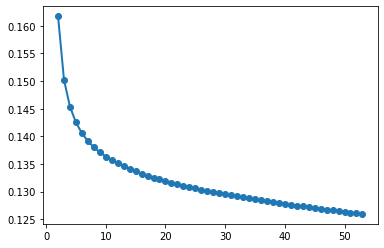

In [14]:
# plot the loss of your logistic classifier over time
# The y-axis should be loss, and the x-axis should be the epoch
# The plot doesn't need to be pretty, just show the loss going down over time!
plt.plot(range(2, len(loss)+1), loss[1:], linewidth=2, linestyle='-', marker='o')

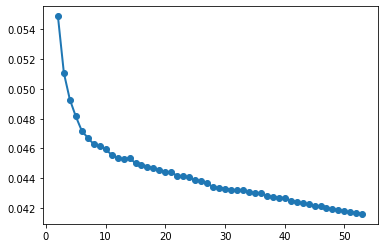

In [15]:
# plot the error of your logistic classifier over time 
plt.plot(range(2, len(err)+1), err[1:], linewidth=2, linestyle='-', marker='o')

In [16]:
pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}'

In [17]:
test_loss, test_err = logloss_and_error(Xte, yte8, w)

In [18]:
print(pstr.format(test_loss, test_err))

Test  Loss: 0.127  Error: 0.045


In [19]:
# We want to visualize w
# First, we bound the entries of w within 3 standard deviations
# (in order to ignore outliers which would mess up the image)
image_w = np.maximum(np.minimum(w, 3 * np.std(w)), -3 * np.std(w))
# Next, we just re-shape image_w into the original 28 by 28 shape of the image
image_w = image_w[0:-1].reshape(28, 28)

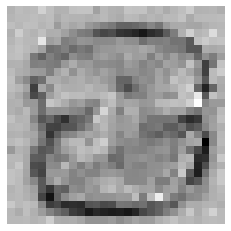

In [20]:
# Visualize image_w
plt.axis('off')
plt.imshow(image_w, cmap='gray')

In [21]:
# the indices in Xtest of images which are "8" but classified incorrectly
# by your classifier
ind = (np.argwhere(((yte8 == 1) * (np.matmul(Xte, w) < 0))))[:,0]

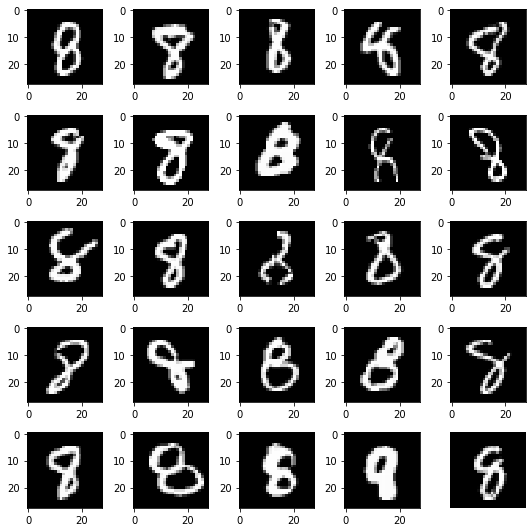

In [22]:
# Display 25 images of "8"s which your classifier incorrectly classified as non-8
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')

In [23]:
# A handle is a convenient way to pass in many arguments/specifications
# to your function. In this case, the logistic SGD handle holds
# parameters such as the gradient function, the loss function, and learning rate.

# Fill in the missing parameters in the handle below, and experiment with
# different values for them!
# For the final submission, use the parameters you found worked best
# (We will not be too picky with your parameters but we do expect them
# to be good enough for your SGD to properly learn)
def prepare_logistic_sgd_handle():
    h = dict()
    h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}'
    h['epochs'] = 100
    h['eta'] = 0.1 * np.ones(h['epochs'])
    h['grad'] = logloss_gradient
    h['loss'] = logloss
    h['error'] = error
    h['batch_size'] = 1000
    h['replace'] = 0
    h['eps'] = 0.001
    return h

In [24]:
# Implement the termination condition (it can be similar to your
# termination condition for coordinate descent)
def terminate(p_loss, c_loss, eps):
    if c_loss > p_loss:
        return False
    return (p_loss - c_loss) / c_loss < eps

In [25]:
# Implement logistic regression with SGD
# h is the handle you defined above
def sgd(X, y, h):
    loss, error, grad, eta = h['loss'], h['error'], h['grad'], h['eta']
    epochs, bs, replace = h['epochs'], h['batch_size'], h['replace']
    eps, pstr = h['eps'], h['pstr']
    n, d = X.shape
    nbs = int(n / bs)
    w = np.zeros((d, 1))
    losses = [loss(X, y, w)]
    errors = [error(X, y, w)]
    sampler = IndexSampler(nbs)
    for e in range(1, epochs * nbs):
        head = sampler.sample_new_index(replace) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        print(w.shape)
        print(Xt.shape)
        print(yt.shape)
        gw = logloss_gradient(Xt, yt, w)
        w -= eta[e // nbs] * gw
        if e % nbs == 0:
            losses.append(loss(X, y, w))
            errors.append(error(X, y, w))
            print(pstr.format(e // nbs, losses[-1], errors[-1]))
            if terminate(losses[-2], losses[-1], eps): break
    print('\n')
    return w, losses, errors

In [26]:
[w_sgd, loss_sgd, error_sgd] = sgd(Xtr, ytr8, prepare_logistic_sgd_handle())

(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)

(785, 1)
(1000, 785)
(1000, 1)
Epoch:  5  Loss: 0.158  Error: 0.053
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 10  Loss: 0.150  Error: 0.051
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 15  Loss: 0.146  Error: 0.049
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 20  Loss: 0.145  Error: 0.051
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 25  Loss: 0.143  Error: 0.048
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 30  Loss: 0.140  Error: 0.047
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 35  Loss: 0.139  Error: 0.046
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
Epoch: 40  Loss: 0.139  Error: 0.048
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 45  Loss: 0.137  Error: 0.048
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 50  Loss: 0.136  Error: 0.045
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

Epoch: 55  Loss: 0.134  Error: 0.044
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

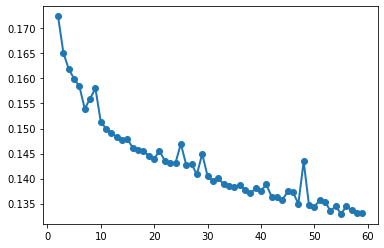

In [27]:
# plot the loss of your SGD classifier over time
plt.plot(range(2, len(loss_sgd)+1), loss_sgd[1:], linewidth=2, linestyle='-', marker='o')

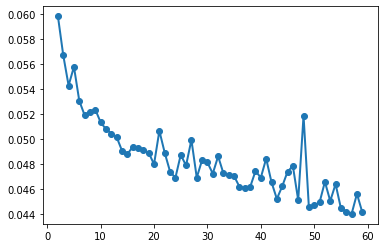

In [28]:
# plot the error of your SGD classifier over time
plt.plot(range(2, len(error_sgd)+1), error_sgd[1:], linewidth=2, linestyle='-', marker='o')

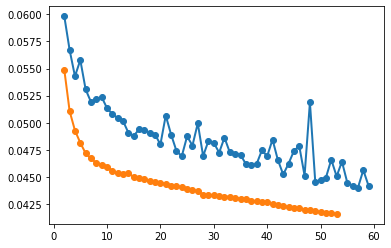

In [29]:
# plot the error of your SGD classifier and CD classifer on the same graph
plt.plot(range(2, len(error_sgd)+1), error_sgd[1:], linewidth=2, linestyle='-', marker='o')
plt.plot(range(2, len(err)+1), err[1:], linewidth=2, linestyle='-', marker='o')
plt.show()

In [30]:
# this is similar to above
ind = (np.argwhere(((yte8 == 1) * (np.matmul(Xte, w_sgd) < 0))))[:,0]

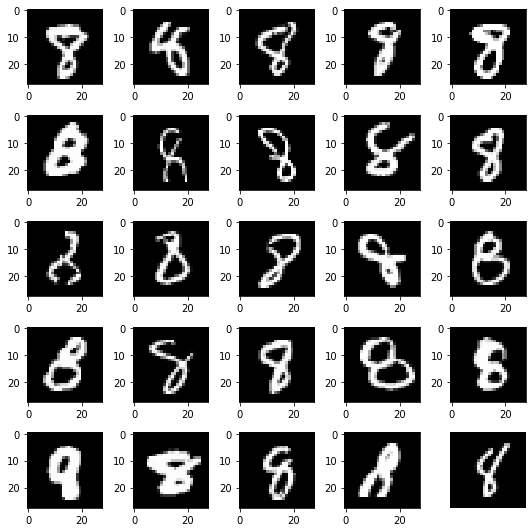

In [31]:
# Display 25 images of "8"s which your classifier incorrectly classified as non-8
ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')

### Classifying the digit 1
Now, repeat most of the above steps, except using the digit 1 instead. In particular:
- Obtain training and test labels (yte1 and ytr1) (Xtr and Xte should remain the same)
- Train a new weight vector using either CD or SGD
- Visualize your weight vector for "1"
- Plot the error of your weight vector for 1 over time
- Display images of "1"s which your classifier incorrectly classified as non-1

In [32]:
ytr1 = (2 * (y_train == 1) - 1).reshape(len(y_train), 1)
yte1 = (2 * (y_test == 1) - 1).reshape(len(y_test), 1)

[w_1, loss_1, error_1] = sgd(Xtr, ytr1, prepare_logistic_sgd_handle())

(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)

(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
Epoch:  5  Loss: 0.033  Error: 0.010
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(7

(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)
(1000, 785)
(1000, 1)
(785, 1)

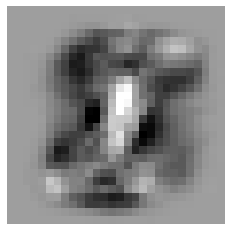

In [33]:
image_w_1 = np.maximum(np.minimum(w_1, 3 * np.std(w_1)), -3 * np.std(w_1))
image_w_1 = image_w_1[0:-1].reshape(28, 28)

plt.axis('off')
plt.imshow(image_w_1, cmap='gray')

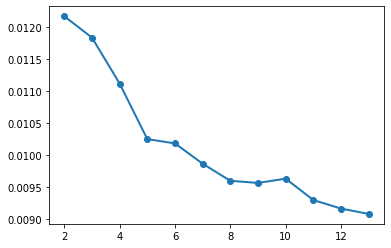

In [34]:
# plot the error of your SGD classifier over time
plt.plot(range(2, len(error_1)+1), error_1[1:], linewidth=2, linestyle='-', marker='o')

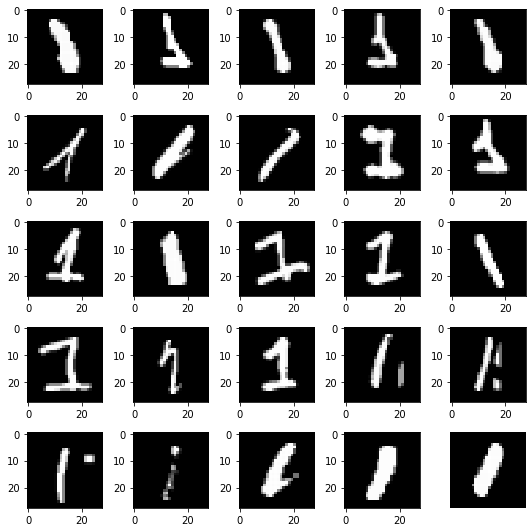

In [35]:
# Display 25 images of "1"s which your classifier incorrectly classified as non-8
ind = (np.argwhere(((yte1 == 1) * (np.matmul(Xte, w_1) < 0))))[:,0]

ncols, nrows = 5, 5
fig, axes = plt.subplots(ncols, nrows, figsize=(1.5*ncols, 1.5*nrows))
for i in range(ncols * nrows):
    ax = axes[i//ncols, i%ncols]
    x = X_test[ind[i],:,:].reshape(28,28)
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(x, cmap='gray')